# 2.1_eda

The following notebook contains the EDA phase of this project. It is important to note that when the initial EDA was carried out, the direction of the project was still unknown. At the time of EDA, only 99 reports had been collected. Hence, the dataframe used for EDA is based on 99 companies from the S+P500, with an even split of 9 companies across 11 industries. 

The purpose of this EDA was to gain insight into the contents of the reports, and to help tinker with the preprocessing stage. It also allowed an exploration into whether there were differences in focus topics between different industries. This would ultimately help to influence the direction this project would go in. 

Although each iteration is not presented here, it is important to note that what is shown in this notebook is the result of many iterations. Each iteration involved alternating between tweaking the text cleaning stage, and seeing what words appeared in the visualisations.

### Package Imports

In [72]:
# general imports
import pandas as pd
import numpy as np
import capstone_utility_functions as cuf
import seaborn as sns
import matplotlib.pyplot as plt

# webscraping imports
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests

# misc imports
import joblib
import re
import io 
from PyPDF2 import PdfReader

# NLP imports
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk.corpus
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string


### Import data

Note, this csv file was built from one of the earlier notebooks which has since been superseded. The process is identical to that shown in '1.1_text_collection' notebook. The dataframe is provided as a csv, so to reproduce this notebook simply load in this csv file. 

Also note that at this stage, it was unclear that splitting reports by paragraphs was optimal. Hence, the reports are retained as a single corpus of text, with **each row** of the dataframe representing a **report**.

In [73]:
df = pd.read_csv('../data/report_bank_v2.csv', index_col=0)

In [74]:
df.head()

,symbol,sector,name,raw_text,word_count
0,FOX,Communication Services,Fox Corporation (Class B),CORPORATESOCIALRESPONSIBILITY report 2021 CELE...,76796
1,CHTR,Communication Services,Charter Communications,"CHARTER COMMUNICATIONS, INC. 2021 Environmenta...",89975
2,VZ,Communication Services,Verizon,Verizon 2021 ESG Report About this report This...,172803
3,LUMN,Communication Services,Lumen Technologies,ESG Report 2021 OUR JOURNEY TO AMAZING THINGS ...,115418
4,ATVI,Communication Services,Activision Blizzard,"ENVIRONMENTAL , SOCIAL , ANDGOVERNANCE REPORT ...",70371


### Cleaning Text

Note that for the purpose of this EDA, it has been decided to not lemmatize words, and to keep all Part of Speech (nouns, verbs, adjectives etc), to see what outputs we get with the least editing we can get away with. 

In [75]:
noisy = ['clients','west','percent','letter','sustainability','report','appendix','management','team','social','corporate','responsibility','business','pages','introduction']
df['clean_paras'] = [cuf.my_cleaner(x,3,noisy_words = noisy,newLineRemove = False,lemmatization=False,nouns = False,) for x in df.raw_text]

In [76]:
#join tokenised words
for index, row in df.iterrows():
    df.iloc[index,5] = ' '.join(df.iloc[index,5])

In [77]:
df.sample(3)

,symbol,sector,name,raw_text,word_count,clean_paras
75,FCX,Materials,Freeport-McMoRan,2021 Annual Report on Sustainability ELECTRIFY...,284197,annual electrifying future freeport mcmoran fr...
81,VTR,Real Estate,Ventas,TABLE OF CONTENTS 04 A Message From our CEO 06...,61174,table contents message adapting covid ventas g...
70,MSI,Information Technology,Motorola Solutions,CORPORATERESPONSIBILITY REPORT202121 BROWN02 R...,98839,corporateresponsibility brown motorola solutio...


In [78]:
joblib.dump(df,'../data/clean_s_and_p_df.pkl')

['../data/clean_s_and_p_df.pkl']

The reports have been tokenised and cleaned.

### Basic EDA

In [79]:
X = df['clean_paras']

In [80]:
X

0     corporatesocialresponsibility celebrating comm...
1     charter communications environmental governanc...
2     verizon details performance topics contains fi...
3     journey amazing things contents empowering peo...
4     environmental andgovernance daniel alegre open...
                            ...                        
94    sust ainability able contents downloadable fil...
95    executive summary sustainable commitment acros...
96    creating clean energy future today table conte...
97    transforming future published table contents a...
98    powering cleaner brighter future customers com...
Name: clean_paras, Length: 99, dtype: object

A key aspect of this EDA is to establish if a TF or TFIDF vectorization is preferable for this application. The reports are vectorized using a TFIDF vectorizer below.

In [81]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 30, max_df=0.5)
tfidf = tfidf.fit(X)
X_trans = tfidf.transform(X)

my_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=X_trans.toarray())
display(my_df)

,abide,abilities,academic,academy,accelerated,accelerating,acceptable,accessibility,accidents,accommodate,...,workplace safety,workplaces,workshop,world class,world resources,written,year employee,year ended,zero carbon,zero emissions
0,0.000000,0.000000,0.013357,0.014419,0.000000,0.000000,0.000000,0.015660,0.000000,0.000000,...,0.000000,0.013523,0.000000,0.000000,0.000000,0.026067,0.0,0.013193,0.000000,0.000000
1,0.009789,0.025918,0.000000,0.000000,0.000000,0.000000,0.000000,0.085561,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.007912,0.0,0.048056,0.000000,0.000000
2,0.000000,0.006853,0.000000,0.006944,0.000000,0.012403,0.014460,0.113119,0.000000,0.015530,...,0.000000,0.000000,0.000000,0.013025,0.000000,0.000000,0.0,0.012707,0.013888,0.026715
3,0.000000,0.000000,0.000000,0.009345,0.000000,0.000000,0.000000,0.000000,0.000000,0.010450,...,0.010297,0.026293,0.000000,0.008764,0.000000,0.000000,0.0,0.017101,0.009345,0.000000
4,0.000000,0.073885,0.000000,0.018715,0.000000,0.000000,0.000000,0.487810,0.000000,0.000000,...,0.000000,0.087762,0.000000,0.000000,0.000000,0.016917,0.0,0.068496,0.018715,0.090004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.000000,0.000000,0.012826,0.000000,0.012219,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.030516,0.012987,0.000000,0.000000,0.013490,0.012516,0.0,0.000000,0.013847,0.053274
95,0.000000,0.000000,0.000000,0.000000,0.000000,0.010159,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.056875,0.010941
96,0.000000,0.000000,0.000000,0.000000,0.000000,0.005771,0.006728,0.007018,0.000000,0.007226,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.005841,0.0,0.000000,0.025848,0.012431
97,0.000000,0.025840,0.000000,0.000000,0.023104,0.035073,0.013631,0.000000,0.014016,0.029278,...,0.000000,0.012278,0.028849,0.000000,0.000000,0.000000,0.0,0.011978,0.209455,0.025183


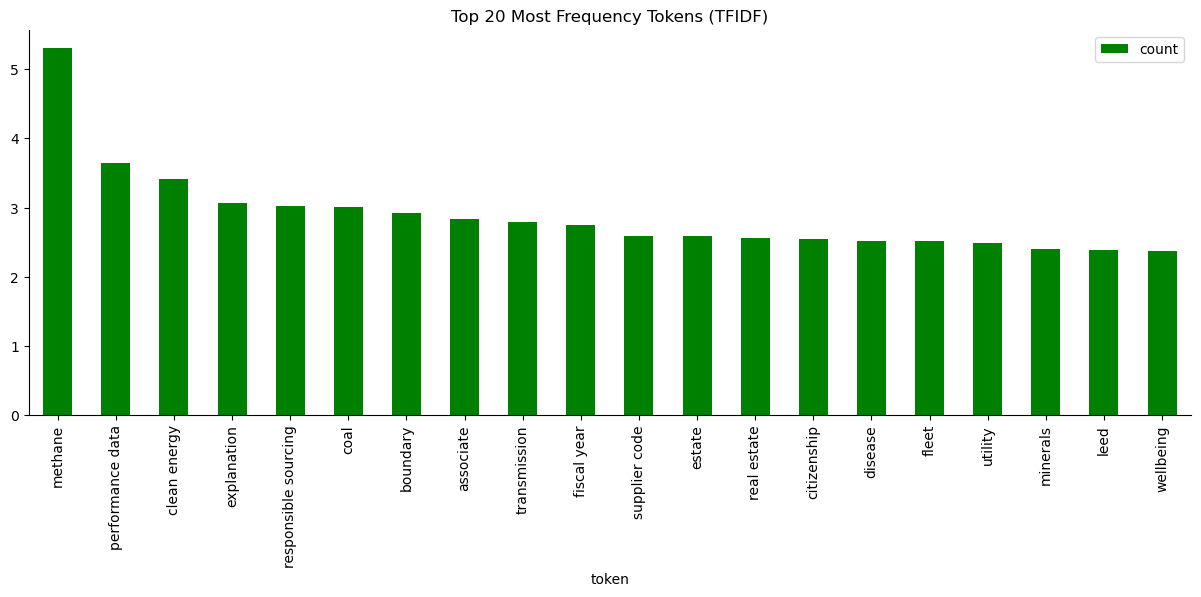

In [82]:
words = tfidf.get_feature_names()
word_weights = X_trans.toarray().sum(axis=0)

cuf.plot_most_frequent(words, word_weights, title = 'Top 20 Most Frequency Tokens (TFIDF)')

The above shows the 20 most common tokens (weighted with TFIDF). The vocabulary is what we would expect from the ESG reports. Let's repeat using TF and observe the difference. Note that bigrams have been included as it can provide additional insight.

In [83]:
tf = CountVectorizer(ngram_range=(1,2), min_df = 30, max_df=0.5)
tf = tf.fit(X)
X_trans = tf.transform(X)

my_df = pd.DataFrame(columns=tf.get_feature_names(), data=X_trans.toarray())
display(my_df)

,abide,abilities,academic,academy,accelerated,accelerating,acceptable,accessibility,accidents,accommodate,...,workplace safety,workplaces,workshop,world class,world resources,written,year employee,year ended,zero carbon,zero emissions
0,0,0,1,1,0,0,0,1,0,0,...,0,1,0,0,0,2,0,1,0,0
1,1,3,0,0,0,0,0,9,0,0,...,0,0,0,0,0,1,0,6,0,0
2,0,1,0,1,0,2,2,15,0,2,...,0,0,0,2,0,0,0,2,2,4
3,0,0,0,1,0,0,0,0,0,1,...,1,3,0,1,0,0,0,2,1,0
4,0,4,0,1,0,0,0,24,0,0,...,0,5,0,0,0,1,0,4,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0,0,1,0,1,0,0,0,0,0,...,2,1,0,0,1,1,0,0,1,4
95,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,5,1
96,0,0,0,0,0,1,1,1,0,1,...,0,0,0,0,0,1,0,0,4,2
97,0,2,0,0,2,3,1,0,1,2,...,0,1,2,0,0,0,0,1,16,2


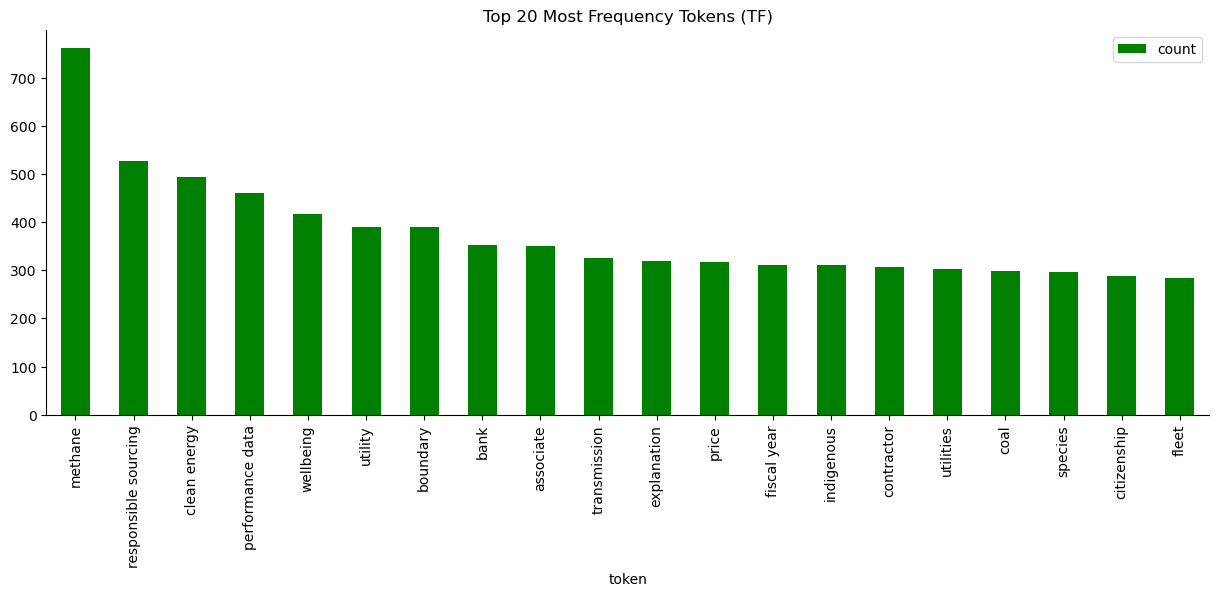

In [84]:
words = tfidf.get_feature_names()
word_weights = X_trans.toarray().sum(axis=0)

cuf.plot_most_frequent(words, word_weights, title = 'Top 20 Most Frequency Tokens (TF)')

From the above, there is no obvious difference between the usefulness of TF or TFIDF. More exploration is needed.

#### Exploring industry trends (TFIDF)

When exploring trends of topics/words mentioned in different industries, TFIDF and TF are both explored. The below section looks at TFIDF.

In [85]:
tfidf = TfidfVectorizer(ngram_range=(1,1), min_df = 20, max_df=0.5)
tfidf = tfidf.fit(X)
X_trans = tfidf.transform(X)

my_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=X_trans.toarray())
display(my_df)

,abide,abilities,abuse,academic,academy,accelerated,accelerating,accelerator,accept,acceptable,...,workday,workplaces,workshop,worth,writing,written,yearly,yield,zone,zones
0,0.00000,0.000000,0.000000,0.008869,0.009574,0.000000,0.000000,0.000000,0.011388,0.000000,...,0.000000,0.008979,0.000000,0.022775,0.033625,0.017308,0.000000,0.000000,0.000000,0.0
1,0.01002,0.026532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.008100,0.000000,0.000000,0.000000,0.0
2,0.00000,0.009217,0.079027,0.000000,0.009339,0.000000,0.016681,0.035638,0.000000,0.019448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024634,0.000000,0.000000,0.0
3,0.00000,0.000000,0.000000,0.000000,0.015366,0.000000,0.000000,0.000000,0.036552,0.000000,...,0.000000,0.043234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.00000,0.061632,0.000000,0.000000,0.015612,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020589,0.073208,0.000000,0.000000,0.000000,0.014111,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.00000,0.000000,0.000000,0.013007,0.000000,0.012391,0.000000,0.017861,0.000000,0.000000,...,0.000000,0.013169,0.000000,0.000000,0.016438,0.012692,0.000000,0.000000,0.000000,0.0
95,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010104,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
96,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005027,0.000000,0.000000,0.005861,...,0.000000,0.000000,0.000000,0.006695,0.000000,0.005088,0.007424,0.000000,0.000000,0.0
97,0.00000,0.015723,0.000000,0.000000,0.000000,0.014058,0.021340,0.030395,0.009474,0.008294,...,0.000000,0.007470,0.017554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [86]:
df.head()

,symbol,sector,name,raw_text,word_count,clean_paras
0,FOX,Communication Services,Fox Corporation (Class B),CORPORATESOCIALRESPONSIBILITY report 2021 CELE...,76796,corporatesocialresponsibility celebrating comm...
1,CHTR,Communication Services,Charter Communications,"CHARTER COMMUNICATIONS, INC. 2021 Environmenta...",89975,charter communications environmental governanc...
2,VZ,Communication Services,Verizon,Verizon 2021 ESG Report About this report This...,172803,verizon details performance topics contains fi...
3,LUMN,Communication Services,Lumen Technologies,ESG Report 2021 OUR JOURNEY TO AMAZING THINGS ...,115418,journey amazing things contents empowering peo...
4,ATVI,Communication Services,Activision Blizzard,"ENVIRONMENTAL , SOCIAL , ANDGOVERNANCE REPORT ...",70371,environmental andgovernance daniel alegre open...


In [87]:
df = df.rename(columns={'sector':'industry_sector'})

In [88]:
df_vectorized = pd.concat([df['industry_sector'], my_df],axis=1)
df_vectorized

,industry_sector,abide,abilities,abuse,academic,academy,accelerated,accelerating,accelerator,accept,...,workday,workplaces,workshop,worth,writing,written,yearly,yield,zone,zones
0,Communication Services,0.00000,0.000000,0.000000,0.008869,0.009574,0.000000,0.000000,0.000000,0.011388,...,0.000000,0.008979,0.000000,0.022775,0.033625,0.017308,0.000000,0.000000,0.000000,0.0
1,Communication Services,0.01002,0.026532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.008100,0.000000,0.000000,0.000000,0.0
2,Communication Services,0.00000,0.009217,0.079027,0.000000,0.009339,0.000000,0.016681,0.035638,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024634,0.000000,0.000000,0.0
3,Communication Services,0.00000,0.000000,0.000000,0.000000,0.015366,0.000000,0.000000,0.000000,0.036552,...,0.000000,0.043234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,Communication Services,0.00000,0.061632,0.000000,0.000000,0.015612,0.000000,0.000000,0.000000,0.000000,...,0.020589,0.073208,0.000000,0.000000,0.000000,0.014111,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Utilities,0.00000,0.000000,0.000000,0.013007,0.000000,0.012391,0.000000,0.017861,0.000000,...,0.000000,0.013169,0.000000,0.000000,0.016438,0.012692,0.000000,0.000000,0.000000,0.0
95,Utilities,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010104,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
96,Utilities,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005027,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.006695,0.000000,0.005088,0.007424,0.000000,0.000000,0.0
97,Utilities,0.00000,0.015723,0.000000,0.000000,0.000000,0.014058,0.021340,0.030395,0.009474,...,0.000000,0.007470,0.017554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


We now have the vectorized words in a dataframe. The reports now just need to be grouped by industry.

In [89]:
df_vectorized = df_vectorized.groupby('industry_sector').sum()

In [90]:
df_vectorized_array = df_vectorized.values

In [91]:
len(df_vectorized_array)

11

The below cell creates a dataframe with the top 10 tokens for each industry, and the respective frequency of the tokens. This is placed in a dictionary 'values_di'.

In [92]:
values_di = {}
sector_di = {}

for j in range(11):
    values_di = {}
    for i in range(len(df_vectorized_array)):
        words = []
        values = []
        top_ten_indices = np.argsort(-df_vectorized_array[i])[:10]
        for idx in top_ten_indices:
            words.append(df_vectorized.columns[idx])
            values.append(df_vectorized_array[i][idx])
        values_di[df_vectorized.index[i]] = dict(zip(words, values))


In [93]:
df_clean_ind = pd.DataFrame.from_dict(values_di['Communication Services'], orient='index', columns=['count'])
df_clean_ind

,count
news,1.350218
internet,1.234653
advertising,1.233527
entertainment,0.949936
paramount,0.814231
angeles,0.763562
accessibility,0.750224
spectrum,0.684544
stories,0.641963
screen,0.596479


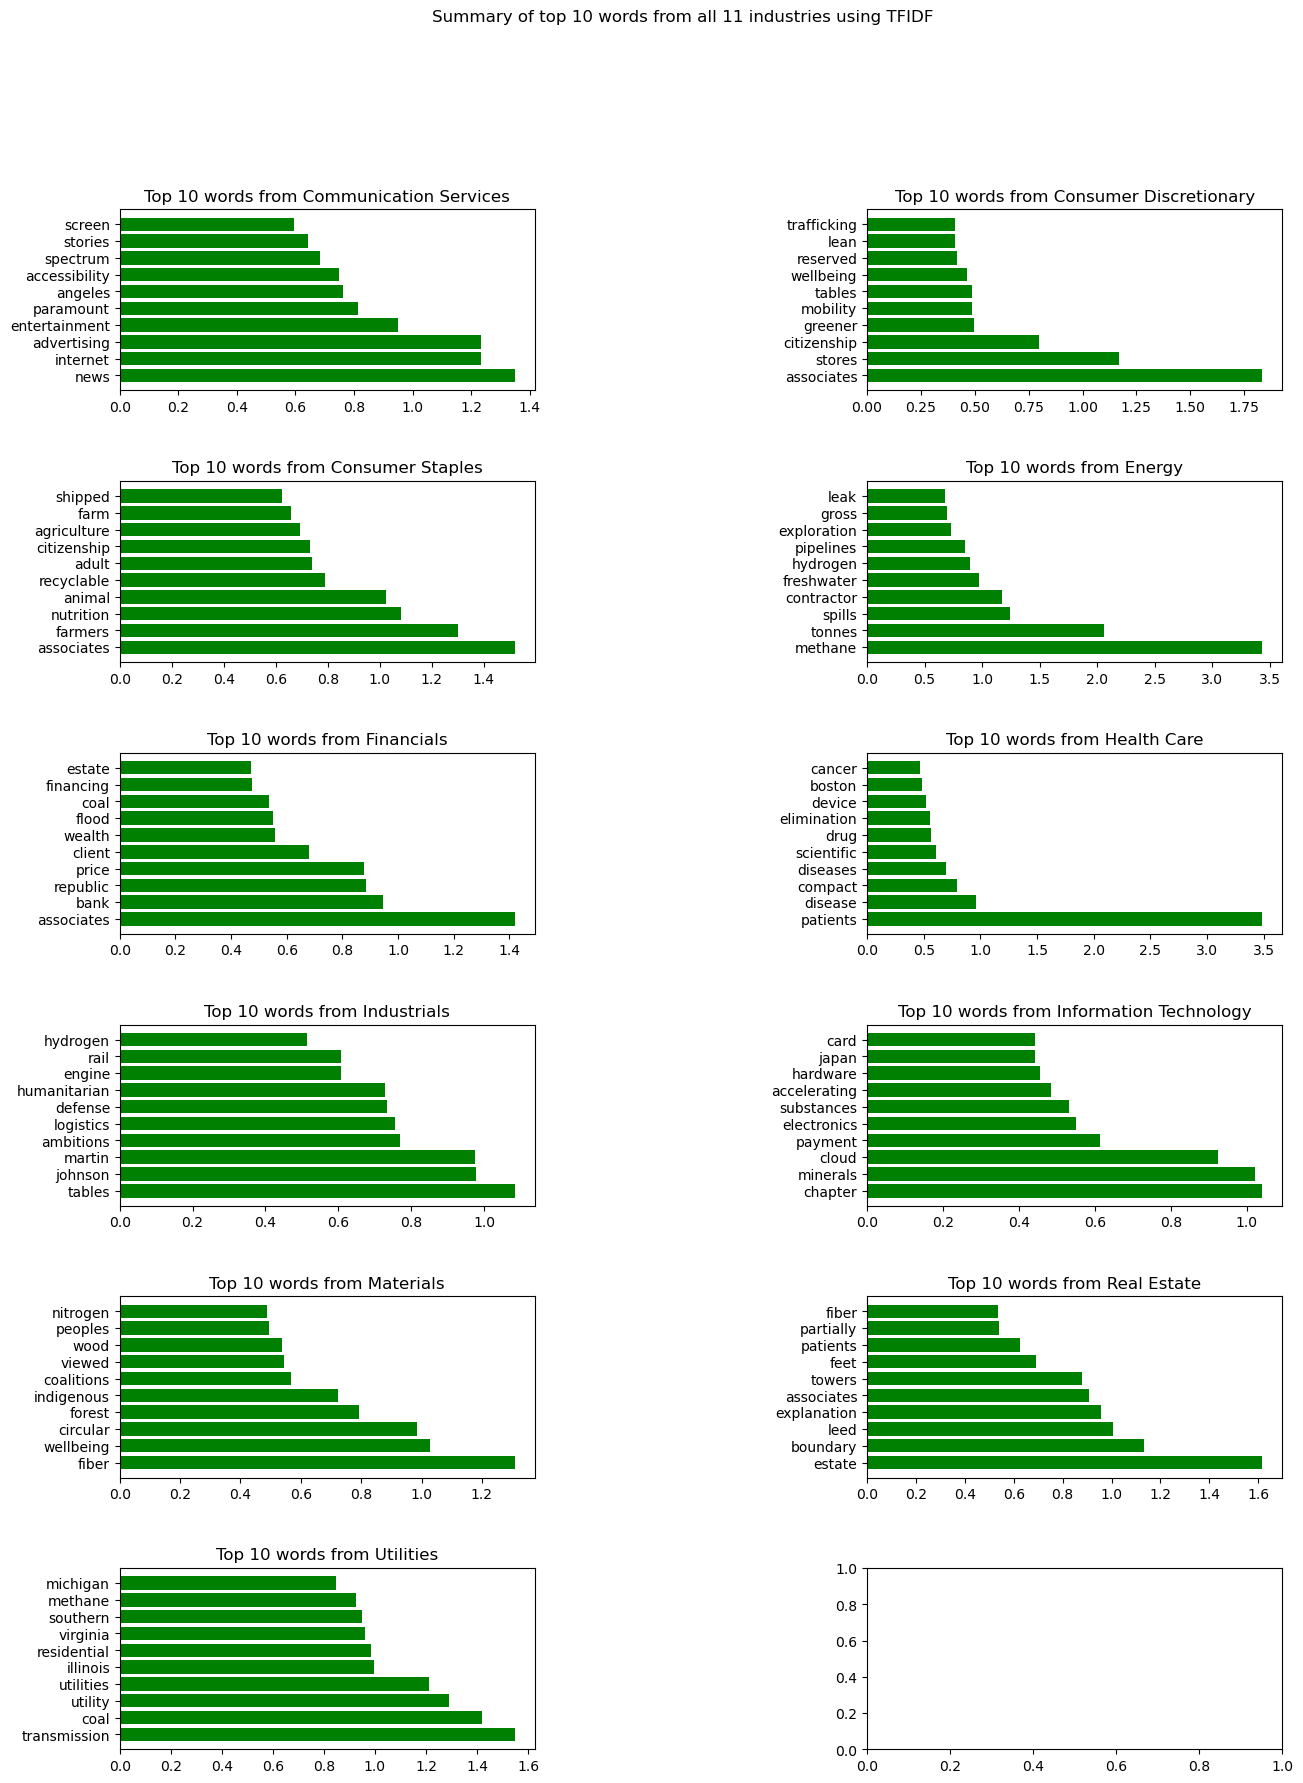

In [94]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.8) 
fig.suptitle('Summary of top 10 words from all 11 industries using TFIDF')
i = 0
j = 0
k = 0 
for sector in df_vectorized.index:
    df_clean_ind = pd.DataFrame.from_dict(values_di[sector], orient='index', columns=['count'])
    ax = axes[j, k] 
    ax.barh(df_clean_ind.index, df_clean_ind['count'], color='g') 
    ax.set_title('Top 10 words from ' + df_vectorized.index[i]) 
    k += 1 # increment k
    if k == 2:   # if k reaches 3, reset to 0 and increment j
        k = 0
        j += 1
    i+=1
        
plt.show()

#### Exploring industry trends (TF)

The above process is repeated, but using TF this time instead of TFIDF.

In [95]:
tf = CountVectorizer(ngram_range=(1,1), min_df = 20, max_df=0.5)
tf = tf.fit(X)
X_trans = tf.transform(X)

my_df = pd.DataFrame(columns=tf.get_feature_names(), data=X_trans.toarray())
display(my_df)

,abide,abilities,abuse,academic,academy,accelerated,accelerating,accelerator,accept,acceptable,...,workday,workplaces,workshop,worth,writing,written,yearly,yield,zone,zones
0,0,0,0,1,1,0,0,0,1,0,...,0,1,0,2,3,2,0,0,0,0
1,1,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,7,0,1,0,2,3,0,2,...,0,0,0,0,0,0,2,0,0,0
3,0,0,0,0,1,0,0,0,2,0,...,0,3,0,0,0,0,0,0,0,0
4,0,4,0,0,1,0,0,0,0,0,...,1,5,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0,0,0,1,0,1,0,1,0,0,...,0,1,0,0,1,1,0,0,0,0
95,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,1,1,0,0,0
97,0,2,0,0,0,2,3,3,1,1,...,0,1,2,0,0,0,0,0,0,0


In [96]:
df.head()

,symbol,industry_sector,name,raw_text,word_count,clean_paras
0,FOX,Communication Services,Fox Corporation (Class B),CORPORATESOCIALRESPONSIBILITY report 2021 CELE...,76796,corporatesocialresponsibility celebrating comm...
1,CHTR,Communication Services,Charter Communications,"CHARTER COMMUNICATIONS, INC. 2021 Environmenta...",89975,charter communications environmental governanc...
2,VZ,Communication Services,Verizon,Verizon 2021 ESG Report About this report This...,172803,verizon details performance topics contains fi...
3,LUMN,Communication Services,Lumen Technologies,ESG Report 2021 OUR JOURNEY TO AMAZING THINGS ...,115418,journey amazing things contents empowering peo...
4,ATVI,Communication Services,Activision Blizzard,"ENVIRONMENTAL , SOCIAL , ANDGOVERNANCE REPORT ...",70371,environmental andgovernance daniel alegre open...


In [97]:
df = df.rename(columns={'sector':'industry_sector'})

In [98]:
df_vectorized = pd.concat([df['industry_sector'], my_df],axis=1)
df_vectorized

,industry_sector,abide,abilities,abuse,academic,academy,accelerated,accelerating,accelerator,accept,...,workday,workplaces,workshop,worth,writing,written,yearly,yield,zone,zones
0,Communication Services,0,0,0,1,1,0,0,0,1,...,0,1,0,2,3,2,0,0,0,0
1,Communication Services,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Communication Services,0,1,7,0,1,0,2,3,0,...,0,0,0,0,0,0,2,0,0,0
3,Communication Services,0,0,0,0,1,0,0,0,2,...,0,3,0,0,0,0,0,0,0,0
4,Communication Services,0,4,0,0,1,0,0,0,0,...,1,5,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Utilities,0,0,0,1,0,1,0,1,0,...,0,1,0,0,1,1,0,0,0,0
95,Utilities,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
96,Utilities,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,1,0,0,0
97,Utilities,0,2,0,0,0,2,3,3,1,...,0,1,2,0,0,0,0,0,0,0


We now have the vectorized words in a dataframe. The reports now just need to be grouped by industry.

In [99]:
df_vectorized = df_vectorized.groupby('industry_sector').sum()

In [100]:
df_vectorized_array = df_vectorized.values

In [101]:
len(df_vectorized_array)

11

The below cell creates a dataframe with the top 10 tokens for each industry, and the respective frequency of the tokens. This is placed in a dictionary 'values_di'.

In [102]:
values_di = {}
sector_di = {}

for j in range(11):
    values_di = {}
    for i in range(len(df_vectorized_array)):
        words = []
        values = []
        top_ten_indices = np.argsort(-df_vectorized_array[i])[:10]
        for idx in top_ten_indices:
            words.append(df_vectorized.columns[idx])
            values.append(df_vectorized_array[i][idx])
        values_di[df_vectorized.index[i]] = dict(zip(words, values))


In [103]:
df_clean_ind = pd.DataFrame.from_dict(values_di['Communication Services'], orient='index', columns=['count'])
df_clean_ind

,count
paramount,223
advertising,189
news,151
screen,133
internet,122
entertainment,105
stories,90
creative,79
angeles,71
spectrum,71


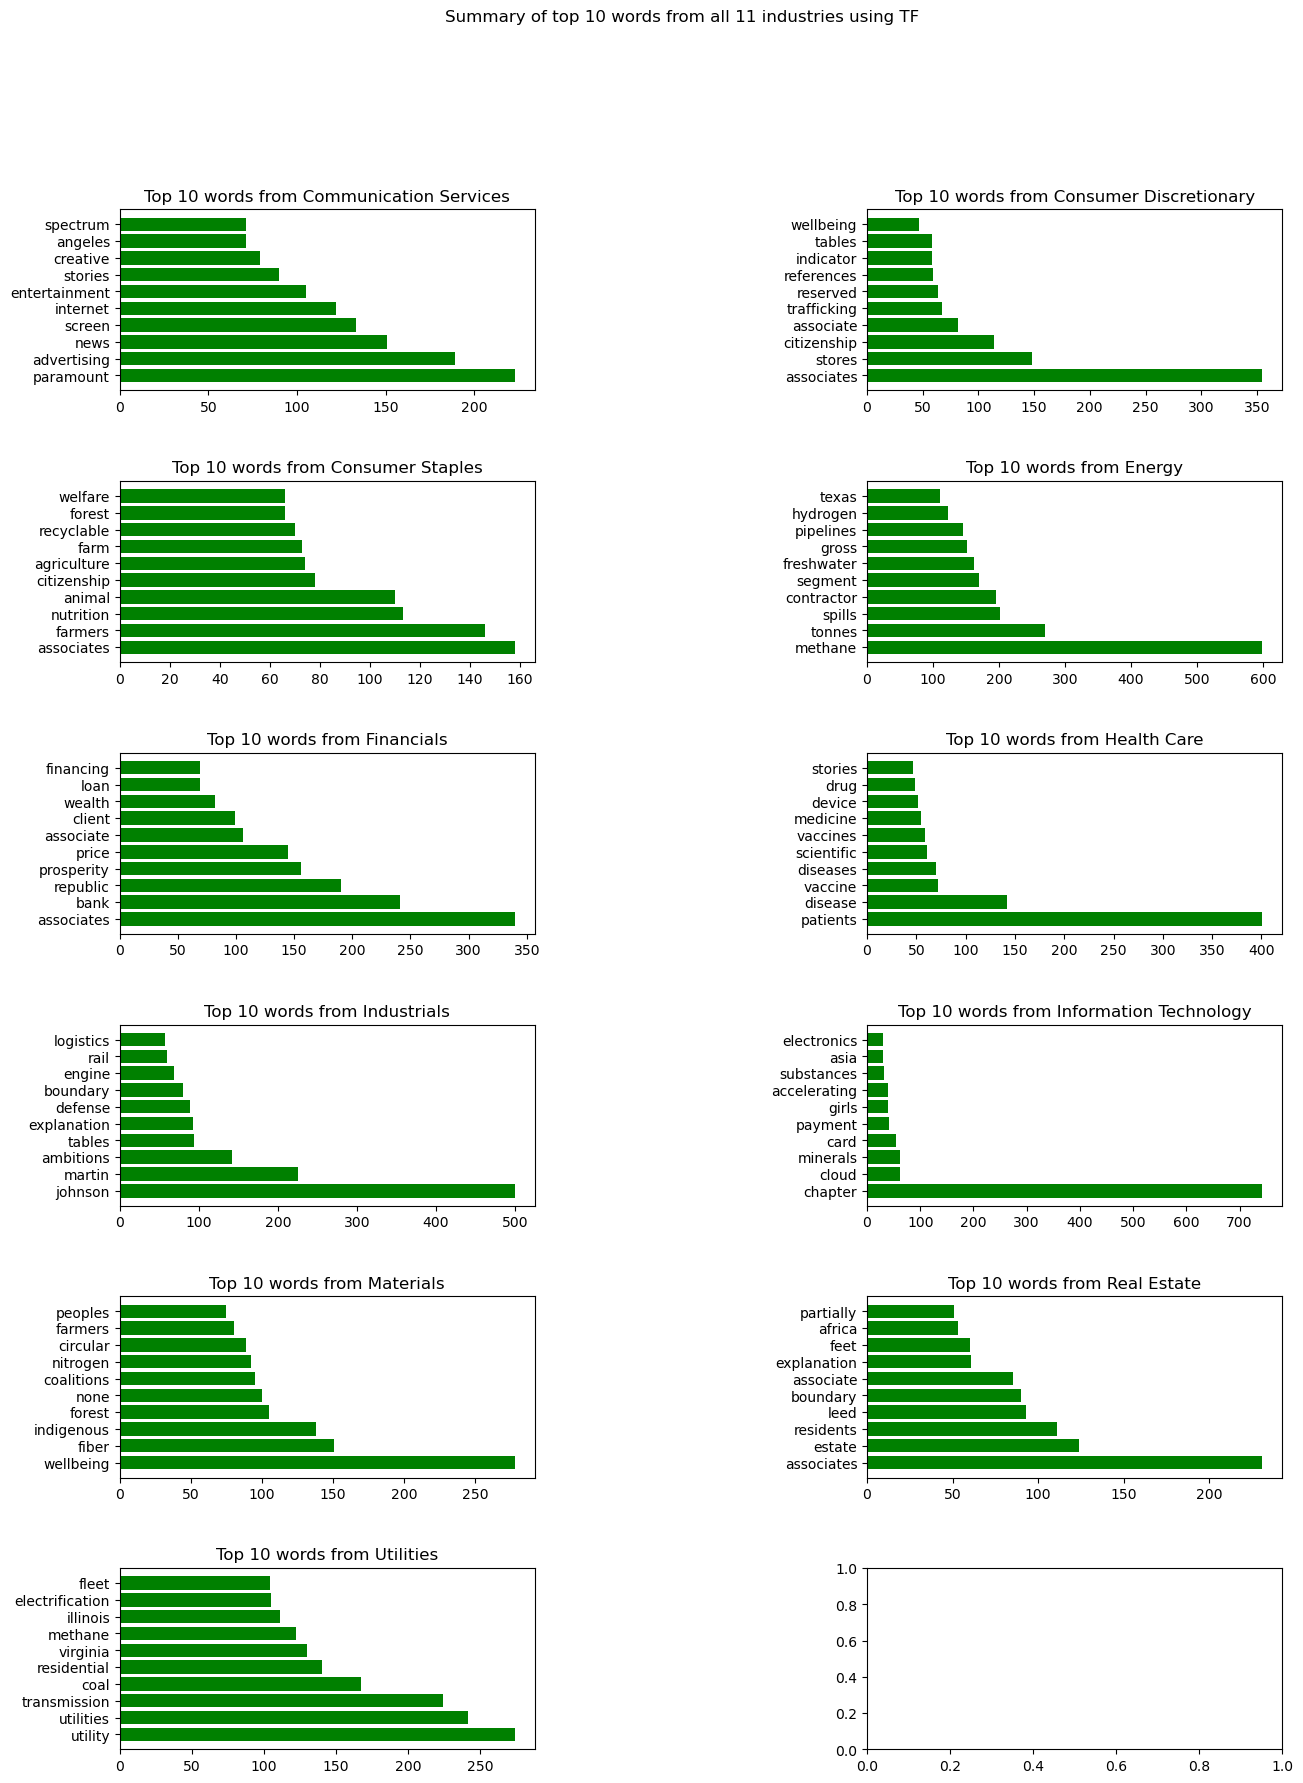

In [104]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20)) 
fig.subplots_adjust(hspace=0.5, wspace=0.8) 
fig.suptitle('Summary of top 10 words from all 11 industries using TF')
i = 0
j = 0
k = 0 
for sector in df_vectorized.index:
    df_clean_ind = pd.DataFrame.from_dict(values_di[sector], orient='index', columns=['count'])
    ax = axes[j, k] 
    ax.barh(df_clean_ind.index, df_clean_ind['count'], color='g') 
    ax.set_title('Top 10 words from ' + df_vectorized.index[i]) 
    k += 1 
    if k == 2:   
        k = 0
        j += 1
    i+=1
        
plt.show()

There is clearly a difference in the focus of the ESG reports when it comes to comparing the industries.The Materials industry for example is much more focused on the environmental topics, with 'forest', 'indigenous' and 'farmers' jumping out.

The Financials industry on the other hand is much more focused on governance-related terms, such as 'associate', 'bank' and 'prosperity'.

This could definitely be of interest when considering how to represent the results from any modelling to the end user - an option to filter by industry could provide interesting cross comparison between reports.

Due to the way that TFIDF works, you see a much more even distribution when it comes to the relative 'frequency'. The top words are actually very similar to those chosen using TF, but it is less impacted by the fact that some reports which are particularly long in length could skew the common terms. 

Hence, going forward TFIDF is preferable. 

#### Word count distribution of reports

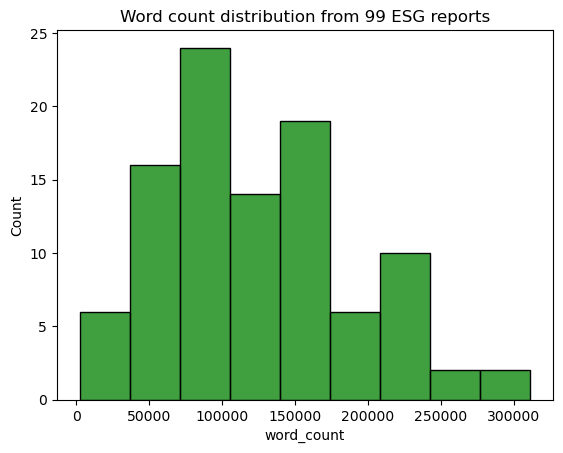

In [105]:
sns.histplot(data=df.word_count, color='g')
plt.title('Word count distribution from 99 ESG reports');

The report lengths are roughly normally distributed.

### Summary

Having carried out an initial EDA phase, the modelling phase was carried out. This phase is split into two paths, as even at this stage of the project it was still unknown which direction it would go in.

One area of the modelling explored how this project could be turned into a supervised learning project, looking at feature engineering and clustering to identify if this was feasible (see Notebook 3.2).

The other looked at LDA Topic Models as an unsupervised approach (see Notebook 3.1). This was the method that was ultimately taken forward.